# Fitting Test Distribution

This notebook take our currently best public-test predictions (according to the leaderboard, updated to 27/4/19), and the distribution of the ttf in the test data (according to the paper from which the data have arguably come), and projects the predictions on the known distribution - through quantile-to-quantile conversion (which preserves order of predictions).

Due to suspected low accuracy in long-times predictions, a middle version will be tried as well, in which the projection is only done for segments with predicted time < 6s.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
from pathlib import Path
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools

In [3]:
# load submission
path = Path('best_submission')
df = pd.read_csv(path/'submission-042.csv')
n = len(df)
print(df.head())
print(df.info())
print(df.describe())

       seg_id  time_to_failure
0  seg_00030f         2.347515
1  seg_0012b5         4.450430
2  seg_00184e         4.452916
3  seg_003339         6.786396
4  seg_0042cc         5.562557
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 2 columns):
seg_id             2624 non-null object
time_to_failure    2624 non-null float64
dtypes: float64(1), object(1)
memory usage: 41.1+ KB
None
       time_to_failure
count      2624.000000
mean          4.222861
std           1.886306
min           0.000000
25%           2.663451
50%           3.952185
75%           5.743191
max           8.780548


In [4]:
# get distribution
class Projector:
    def __init__(self,
                 lengths=None, group='train',
                 train_lengths=(11.332904, 14.255248, 8.654088, 12.794076, 7.923502, 7.192916, 15.959949,
                                7.923502, 9.628203, 11.332904, 11.089375, 8.654088, 8.654088, 14.742305, 9.384674),
                 test_lengths=(9.72, 12.550547, 11.332904,  7.436445, 11.332904,
                               16.447006,  9.628203, 12.550547, 16.690535),
                 segs_per_sec=(4096/0.001064)/150e3,
                 verbose=False
                ):
        
        if lengths is None:
            if group=='train':
                lengths = train_lengths
            elif group=='test':
                lengths = test_lengths
            else:
                raise IOError('Invalid group.')
                
        lengths = sorted(lengths)
        n_quakes = len(lengths)
        lengths = [0] + lengths
        dls = np.diff(lengths)
        segs_per_interval = [(n_quakes-i)*l*segs_per_sec for i,l in enumerate(dls)]
        segs_per_interval_norm = segs_per_interval/sum(segs_per_interval)
        segs_thresholds = np.concatenate(([0],np.cumsum(segs_per_interval_norm)))

        if verbose:
            print(lengths)
            print(dls)
            print(np.cumsum(segs_per_interval))
            print(segs_thresholds)
            
        self.lengths = lengths
        self.thresholds = segs_thresholds
        
    def q2t(self, q):
        i_seg = sum(q>self.thresholds)
        x1 = self.thresholds[i_seg-1]
        x2 = self.thresholds[i_seg]
        y1 = self.lengths[i_seg-1]
        y2 = self.lengths[i_seg]
        return y1 + (q-x1)*(y2-y1)/(x2-x1)

    def project_preds(self, preds, thres=np.inf):
        n = len(preds)
        ids = pd.Series(np.zeros(n))
        ids.iloc[np.array(preds.sort_values().index.values, dtype='int16')] = range(n)
        qs = ids / len(ids)
        return np.array([self.q2t(q) if pred<thres and self.q2t(q)<thres else pred
                         for q,pred in zip(qs,preds)])

In [5]:
p = Projector(group='test', verbose=True)

[0, 7.436445, 9.628203, 9.72, 11.332904, 11.332904, 12.550547, 12.550547, 16.447006, 16.690535]
[7.436445 2.191758 0.091797 1.612904 0.       1.217643 0.       3.896459
 0.243529]
[1717.65105564 2167.64808662 2184.13933714 2432.50229895 2432.50229895
 2557.50144    2557.50144    2757.50013754 2763.75010486]
[0.         0.6214929  0.78431407 0.79028105 0.88014553 0.88014553
 0.92537362 0.92537362 0.99773859 1.        ]


Text(0,0.5,'Time [s]')

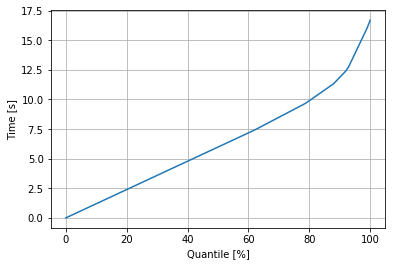

In [6]:
plt.plot(range(101), [p.q2t(i/100) for i in range(101)])
plt.grid()
plt.xlabel('Quantile [%]')
plt.ylabel('Time [s]')

[ 2.18880266  6.88104837  6.89016838 11.48165501  8.82771624]
0.0


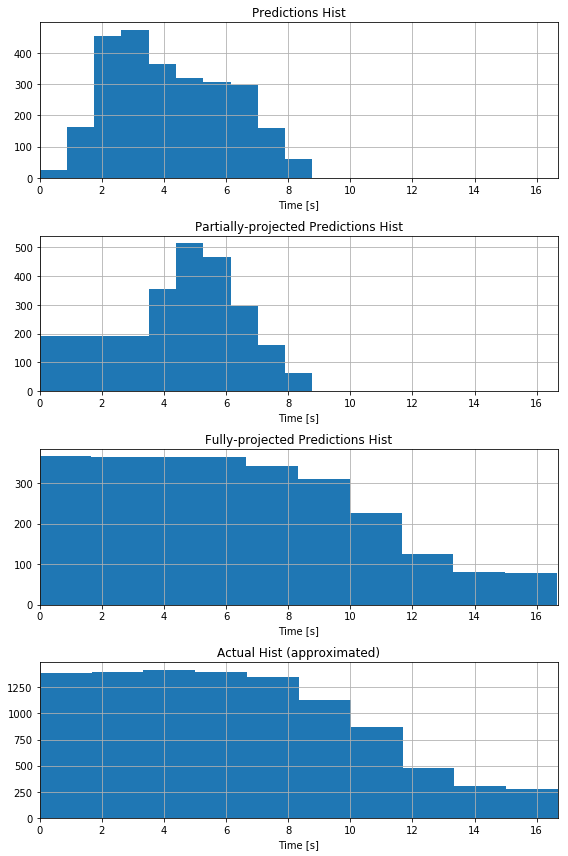

In [7]:
# project predictions on test distribution
y_full = p.project_preds(df.time_to_failure)
y_part = p.project_preds(df.time_to_failure, 6)

print(y_full[:5])
print(y_full[1402])

fig, axs = plt.subplots(4,1, figsize=(8,12))
axs[0].hist(df.time_to_failure)
axs[1].hist(y_part)
axs[2].hist(y_full)
axs[3].hist([p.q2t(x) for x in np.random.random(int(1e4))])
titles = ('Predictions Hist','Partially-projected Predictions Hist','Fully-projected Predictions Hist',
          'Actual Hist (approximated)')
for i,ax in enumerate(axs):
    ax.set_xlim(p.lengths[0],p.lengths[-1])
    ax.grid()
    ax.set_xlabel('Time [s]')
    ax.set_title(titles[i])
plt.tight_layout()

In [8]:
# save new submissions
pd.DataFrame({'seg_id':df.seg_id, 'time_to_failure':y_full}).to_csv(path/'sub_fully_projected.csv', index=False)
pd.DataFrame({'seg_id':df.seg_id, 'time_to_failure':y_part}).to_csv(path/'sub_partially_projected.csv', index=False)